# Multi-Arm Bandits Problem with Reinforcement Learning

This project is extended from:

https://towardsdatascience.com/multi-armed-bandits-and-reinforcement-learning-dc9001dcb8da

Here, we illustrate the effects of
- $\epsilon$ / $\alpha$, which is the probability of exploring (in constrast to exploiting)
- Decay, which reduces the probability of exploring over time

$\epsilon$ / $\alpha$ is important as exploring different options allow the agent to find path to a global maxima, in constrast to getting trapped within a local maxima

Meanwhile, decay is important as we wish to stop exploring after a period of time, as the global maxima may have be found

The best implementation is to use both concepts together.

# Import Libraries

In [1]:
# import modules 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from tqdm import tqdm
%matplotlib inline

np.random.seed(42)

# We define different reward distribution
- Random
- Increasing
- Gaussian

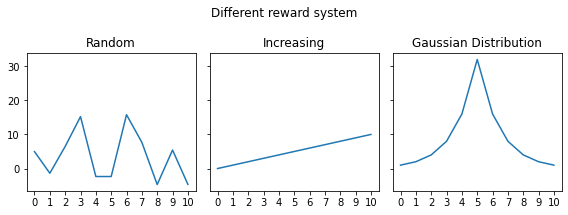

In [2]:
k = 11
np.random.seed(42)

fig, axs = plt.subplots(1,3, figsize=(8, 3), 
                        facecolor='w', edgecolor='k', 
                        sharex=True, sharey=True)

fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

axs[0].plot(np.random.normal(0, 10, k))
axs[0].set_title("Random")
axs[0].set_xticks(list(range(0,k)))
    
axs[1].plot(np.linspace(0, k-1, k))
axs[1].set_title("Increasing")
axs[1].set_xticks(list(range(0,k)))

axs[2].plot([2**x for x in range(int(np.ceil(k/2)))] + 
            [2**x for x in range(int(np.floor(k/2)))][::-1])
axs[2].set_title("Gaussian Distribution")
axs[2].set_xticks(list(range(0,k)))

plt.suptitle('Different reward system')
fig.tight_layout()
plt.show()

# Building a greedy k-Armed Bandit

We compare the k-bandit problem, with and without decay
First, we predefine the alpha, which is the probability of exploring
If decay is enabled, the probability decrease 0.00001 per time step.

In [3]:
class eps_bandit:
    '''
    epsilon-greedy k-bandit problem
    
    Inputs
    =====================================================
    k: number of arms (int)
    eps: probability of random action 0 < eps < 1 (float)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    
    def __init__(self, k, eps, iters, mu='random', decay=False):
        
        self.k = k                    # Number of arms
        self.eps = eps                # Search probability
        self.iters = iters            # Number of iterations
        self.n = 0                    # Step count
        self.k_n = np.zeros(k)        # Step count for each arm
        self.mean_reward = 0          # Total mean reward
        self.reward = np.zeros(iters) 
        self.k_reward = np.zeros(k)   # Mean reward for each arm
        self.decay = decay         # Set decay
        
        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
            
        elif mu == 'random':
            # Draw means from probability distribution
            np.random.seed(42)
            self.mu = np.random.normal(0, 10, k)
            
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)/np.sum(np.linspace(0, k-1, k))
            
        elif mu == 'gaussian':
            # Increase the mean for each arm by one
            self.mu = np.array([2**x for x in range(int(np.ceil(k/2)))] + 
                               [2**x for x in range(int(np.floor(k/2)))][::-1])

        
    def pull(self):
        # Generate random number
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)
            
        reward = np.random.normal(self.mu[a], 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a]) / self.k_n[a]
        
        # Decay eps
        if self.decay == True:
            self.eps = self.eps - 0.00001
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

# Test for different $\alpha$ with no decay

100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


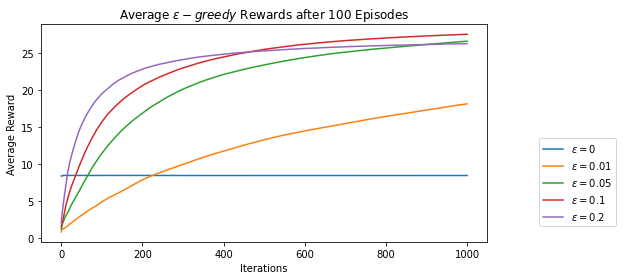

In [4]:
iters = 1000

eps_reward_list = []
eps_selection_list = []

episodes = 100
alpha_list = [0, 0.01, 0.05, 0.1, 0.2]

plt.figure(figsize=(8,4))

# Run experiments
for alpha in tqdm(alpha_list):
    
    eps_rewards = np.zeros(iters)
    eps_selection = np.zeros(k)
    
    for i in range(episodes):
        # Initialize bandits
        eps = eps_bandit(k, alpha, iters, 
                         #mu='random',
                         #mu='sequence',
                         mu='gaussian',
                        )

        # Run experiments
        eps.run()

        # Update long-term averages
        eps_rewards = eps_rewards + (eps.reward - eps_rewards)/(i + 1)

        # Average actions per episode
        eps_selection = eps_selection + (eps.k_n - eps_selection)/(i + 1)
        
    plt.plot(eps_rewards, label=("$\epsilon=$" + str(alpha)))
    
    eps_reward_list.append(eps_rewards)
    eps_selection_list.append(eps_selection)
    
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) + " Episodes")
plt.show()

# Plot selection distribution

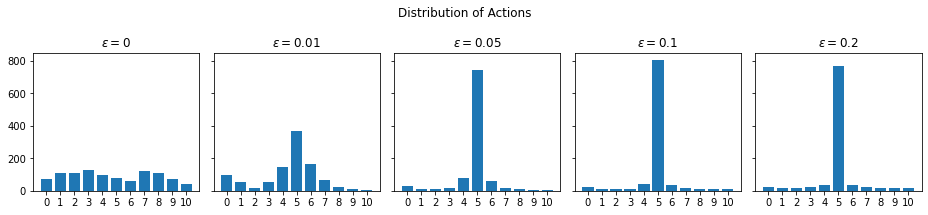

Percentage of actions selected:


,arm=0,arm=1,arm=2,arm=3,arm=4,arm=5,arm=6,arm=7,arm=8,arm=9,arm=10
e=0,7.002,10.999,10.996,13.000,10.000,8.000,6.000,12.000,11.000,7.000,4.003
e=0.01,9.467,5.223,1.733,5.449,14.699,36.870,16.711,6.372,2.400,0.838,0.238
e=0.05,2.893,1.134,0.949,1.948,7.876,74.717,6.320,1.873,1.188,0.553,0.549
e=0.1,2.139,1.281,1.237,1.319,4.343,80.743,3.880,1.813,1.198,1.047,1.000
e=0.2,2.238,1.967,2.019,2.227,3.520,76.795,3.314,2.308,2.003,1.808,1.801


In [5]:
bins = np.linspace(0, k-1, k)

fig, axs = plt.subplots(1,5, figsize=(13, 3), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i, alpha in enumerate(alpha_list):
    axs[i].bar(bins, eps_selection_list[i])
    axs[i].set_title("$\epsilon=$" + str(alpha))
    axs[i].set_xticks(list(range(0,k)))

plt.suptitle('Distribution of Actions')
fig.tight_layout()
plt.show()

opt_per = np.array(eps_selection_list)/iters * 100
df = pd.DataFrame(opt_per, 
                  index=[("e=" + str(alpha)) for alpha in alpha_list],
                  columns=["arm=" + str(x) for x in range(0, k)])
print("Percentage of actions selected:")

df_no_decay = df.copy()
df

# Test for different $\alpha$ with decay

100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


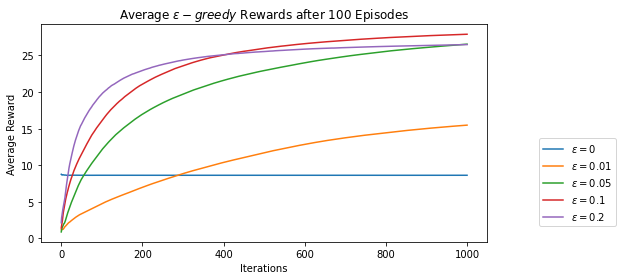

In [6]:
iters = 1000

eps_reward_list = []
eps_selection_list = []

episodes = 100
alpha_list = [0, 0.01, 0.05, 0.1, 0.2]

plt.figure(figsize=(8,4))

# Run experiments
for alpha in tqdm(alpha_list):
    
    eps_rewards = np.zeros(iters)
    eps_selection = np.zeros(k)
    
    for i in range(episodes):
        # Initialize bandits
        eps = eps_bandit(k, alpha, iters, 
                         #mu='random',
                         #mu='sequence',
                         mu='gaussian',
                         decay=True,
                        )

        # Run experiments
        eps.run()

        # Update long-term averages
        eps_rewards = eps_rewards + (eps.reward - eps_rewards)/(i + 1)

        # Average actions per episode
        eps_selection = eps_selection + (eps.k_n - eps_selection)/(i + 1)
        
    plt.plot(eps_rewards, label=("$\epsilon=$" + str(alpha)))
    
    eps_reward_list.append(eps_rewards)
    eps_selection_list.append(eps_selection)
    
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) + " Episodes")
plt.show()

# Plot selection distribution

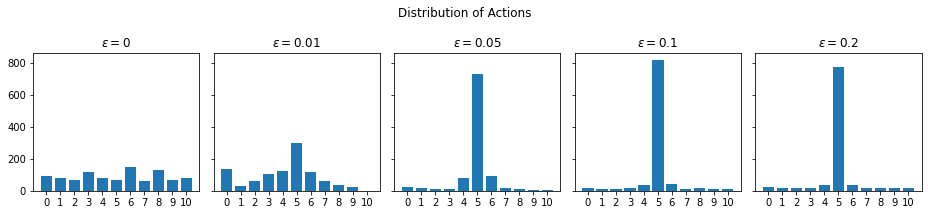

Percentage of actions selected:


,arm=0,arm=1,arm=2,arm=3,arm=4,arm=5,arm=6,arm=7,arm=8,arm=9,arm=10
e=0,8.998,8.000,7.000,12.000,8.000,7.000,15.000,6.000,13.000,7.000,8.002
e=0.01,13.462,2.930,6.000,10.757,12.386,30.177,11.561,6.101,3.852,2.610,0.164
e=0.05,2.325,1.556,0.858,1.141,8.317,73.064,9.255,1.595,0.833,0.592,0.464
e=0.1,1.984,0.960,1.010,1.608,3.480,82.121,4.129,1.409,1.451,0.975,0.873
e=0.2,2.145,1.928,1.980,1.994,3.478,77.551,3.333,2.003,1.921,1.861,1.806


In [7]:
bins = np.linspace(0, k-1, k)

fig, axs = plt.subplots(1,5, figsize=(13, 3), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i, alpha in enumerate(alpha_list):
    axs[i].bar(bins, eps_selection_list[i])
    axs[i].set_title("$\epsilon=$" + str(alpha))
    axs[i].set_xticks(list(range(0,k)))

plt.suptitle('Distribution of Actions')
fig.tight_layout()
plt.show()

opt_per = np.array(eps_selection_list)/iters * 100
df = pd.DataFrame(opt_per, 
                  index=[("e=" + str(alpha)) for alpha in alpha_list],
                  columns=["arm=" + str(x) for x in range(0, k)])
print("Percentage of actions selected:")

df_decay = df.copy()
df

# Compare the results with and without decay
Perform pairwise comparison between the two dataframes df_no_decay vs df_decay

In [8]:
df_compare = df_decay.copy()

for index in list(df_decay.index):
    for column in list(df_decay.columns):
        diff = (df_decay[column][index] - df_no_decay[column][index])/df_no_decay[column][index]
        diff = np.round(diff*100,3)
        df_compare[column][index] = diff
        
df_compare

,arm=0,arm=1,arm=2,arm=3,arm=4,arm=5,arm=6,arm=7,arm=8,arm=9,arm=10
e=0,28.506,-27.266,-36.340,-7.692,-20.000,-12.500,150.000,-50.000,18.182,0.000,99.900
e=0.01,42.199,-43.902,246.220,97.412,-15.736,-18.153,-30.818,-4.253,60.500,211.456,-31.092
e=0.05,-19.634,37.213,-9.589,-41.427,5.599,-2.212,46.440,-14.842,-29.882,7.052,-15.483
e=0.1,-7.246,-25.059,-18.351,21.911,-19.871,1.707,6.418,-22.284,21.119,-6.877,-12.700
e=0.2,-4.155,-1.983,-1.932,-10.463,-1.193,0.984,0.573,-13.215,-4.094,2.931,0.278


# Conclusion
- Too much epilson/alpha affects the model as the agent may explore too much
- Too low of an alpha makes the agent explore too little, and may not find the local maxima
- With decay, the overall results improved when the epilson/alpha is high, but worsen vice versa